# **ETF Forecasting**

The following data set has been provided by BORIS MARJANOVIC on Kaggle. He has allowed free use of the data for personal use. The link to complete data set : https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs/data

We will be using several machine learning algorithms along with statistical methods to train and test out model. We begin by importing all the necessary libraries for this project. 

In [1]:
import os
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score

For this project, we will be creating an **ETF** class that encapsulates all the necessary methods to analyze, modify, and train data models on ETF (Exchange-Traded Fund) data. The class provides functionalities for reading the data, cleaning it, generating descriptive statistics, plotting various financial metrics, and building a linear regression model to predict the closing prices. 

*Note that we are creating a class because all the datasets have same strucutre and heence would have same preprocessing and analysis. In case of a dataset with different structure, we would have to manually clean and  preprocess that data*

## **Overview of the ETF Class**

- **Initialization**:
  - The class is initialized with the name of the ETF, which is used to load the corresponding data file.

- **Methods**:
  - **read_etfs**: Reads the ETF data from a CSV file and loads it into a pandas DataFrame.

  - **describe**: Provides detailed information about the DataFrame, including its structure, statistics, and any missing values.

  - **clean**: Cleans the data by converting the date column, dropping unnecessary columns, and adjusting the volume data for better readability.

  - **plot_folder**: Creates a directory structure to save plots for the ETF.

  - **plot_open_price**, **plot_close_price**, **plot_highs**, **plot_lows**, **plot_volume**: These methods individually handle the creation and saving of line and bar plots for different financial metrics (open price, close price, highs, lows, and volume) over time.

  - **plot_series** and **plot_bar**: Handle the creation of line and bar plots for different financial metrics over time.

  - **ml_preprocess**: Prepares the data for machine learning by adding new features such as day, month, and year extracted from the date.
  
  - **linearModel**: Builds and trains a linear regression model to predict the closing price of the ETF based on several features, and calculates the Mean Squared Error (MSE) and R² score for model evaluation.

With this class, we can efficiently perform a wide range of operations on ETF data, from basic exploratory data analysis to more advanced predictive modeling.

In [2]:
class ETF:
    def __init__(self, name):
        self.name = name
        self.df = self.read_etfs()
        self.cleaned_df = None
        self.r2Score = None
        self.mse = None
        self.trainX = None
        self.trainY  = None
        self.testX = None
        self.testY = None
        self.model = None
        self.features = None
        self.target = None

    def read_etfs(self) -> pd.DataFrame:
        df = pd.read_csv(f"./Data/ETFs/{self.name}.us.txt")
        return df

    def describe(self, df: pd.DataFrame):
        print("DataFrame Information:")
        df.info()
        
        print("\nDescriptive Statistics:")
        print(df.describe())
        
        print("\nFirst 5 Rows:")
        print(df.head())
        
        print("\nLast 5 Rows:")
        print(df.tail())
        
        print("\nDataFrame Shape (rows, columns):")
        print(df.shape)
        
        print("\nRandom Sample of 5 Rows:")
        print(df.sample(5))
        
        print("\nMissing Values Count per Column:")
        print(df.isnull().sum())
        print()

    def clean(self) -> pd.DataFrame:
        df = self.df.copy()
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.drop("OpenInt", axis=1)
        df["Volume"] = df["Volume"] / 10**7
        df = df.rename(columns={"Volume": "Volume in Millions"})
        self.cleaned_df = df
        return df

    def plot_folder(self):
        if not os.path.exists(f"./Plots/ETFs/{self.name}"):
            os.makedirs(f"./Plots/ETFs/{self.name}")
        return

    def plot_open_price(self):
        if self.cleaned_df is None:
            raise ValueError("Data is not cleaned before plotting.")
        self.plot_folder()
        self.plot_series(self.cleaned_df, 'Open', 'Open Price')

    def plot_close_price(self):
        if self.cleaned_df is None:
            raise ValueError("Data is not cleaned before plotting.")
        self.plot_folder()
        self.plot_series(self.cleaned_df, 'Close', 'Close Price')

    def plot_highs(self):
        if self.cleaned_df is None:
            raise ValueError("Data is not cleaned before plotting.")
        self.plot_folder()
        self.plot_series(self.cleaned_df, 'High', 'Highs')

    def plot_lows(self):
        if self.cleaned_df is None:
            raise ValueError("Data is not cleaned before plotting.")
        self.plot_folder()
        self.plot_series(self.cleaned_df, 'Low', 'Lows')

    def plot_volume(self):
        if self.cleaned_df is None:
            raise ValueError("Data is not cleaned before plotting.")
        self.plot_folder()
        self.plot_bar(self.cleaned_df, 'Volume in Millions', 'Volume')

    def plot_series(self, df, column, title):
        plt.figure(figsize=(8, 5))
        plt.plot(df["Date"], df[column], color='royalblue', linestyle='-', linewidth=1, label=title)
        plt.title(f'ETF {title}', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel(title, fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"./Plots/ETFs/{self.name}/{title}.png")

    def plot_bar(self, df, column, title):
        plt.figure(figsize=(8, 5))
        plt.bar(df["Date"], df[column], color='royalblue', label=title)
        plt.title(f'ETF {title}', fontsize=16)
        plt.xlabel('Date', fontsize=14)
        plt.ylabel(title, fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"./Plots/ETFs/{self.name}/{title}.png")

    def ml_preprocess(self, df: pd.DataFrame) -> pd.DataFrame:
        df["Date"] = pd.to_datetime(df["Date"])
        df["Day"] = df["Date"].dt.dayofweek
        df["Month"] = df["Date"].dt.month
        df["Year"] = df["Date"].dt.year
        df = df.drop('Date',axis=1)
        df.dropna(inplace=True)
        return df

    def linearModel(self, df, features, target):
        X = df[features]
        Y = df[target]
        trainX, testX, trainY, testY = train_test_split(X, Y, random_state = 0)
        model = LinearRegression()
        model.fit(trainX, trainY)
        predY = model.predict(testX)
        self.mse = mean_squared_error(testY, predY)
        self.r2Score = r2_score(testY, predY)
        self.trainX = trainX
        self.trainY = trainY
        self.testX = testX
        self.testY = testY
        self.model = model
        self.features = features
        self.target = target

    def dtr(self, df, features, target, mln = None):
        X = df[features]
        Y = df[target]
        trainX, testX, trainY, testY = train_test_split(X, Y, random_state = 0)
        model = DecisionTreeRegressor(random_state = 0, max_leaf_nodes = mln)
        model.fit(trainX, trainY)
        predY = model.predict(testX)
        self.mse = mean_squared_error(testY, predY)
        self.r2Score = r2_score(testY, predY)
        self.trainX = trainX
        self.trainY = trainY
        self.testX = testX
        self.testY = testY
        self.model = model
        self.features = features
        self.target = target

    def dtrCheck(self):
        def get_mae(maxLeaf, trainX, testX, trainY, testY):
            model = DecisionTreeRegressor(max_leaf_nodes = maxLeaf, random_state = 0)
            model.fit(trainX, trainY)
            preds_val = model.predict(testX)
            mae = mean_absolute_error(testY, preds_val)
            return(mae)
        
        for maxLeaf in [5, 50, 500, 5000]:
            my_mae = get_mae(maxLeaf, self.trainX, self.testX, self.trainY, self.testY)
            print(f"Max leaf nodes: {maxLeaf}  \t\t Mean Absolute Error:  {my_mae}")

    def rfr(self, df, features, target):
        X = df[features]
        Y = df[target]
        trainX, testX, trainY, testY = train_test_split(X, Y, random_state = 0)
        model = RandomForestRegressor(random_state = 0)
        model.fit(trainX, trainY)
        predY = model.predict(testX)
        self.mse = mean_squared_error(testY, predY)
        self.r2Score = r2_score(testY, predY)
        self.trainX = trainX
        self.trainY = trainY
        self.testX = testX
        self.testY = testY
        self.model = model
        self.features = features
        self.target = target

    def plotPredictions(self):
        if self.testX is None or self.testY is None:
            raise ValueError("Model has not been trained or data is not prepared.")
        model = self.model
        predY = model.predict(self.testX)  
        plt.figure(figsize=(10, 6))
        plt.scatter(self.testY, predY, color='royalblue', alpha=0.7, edgecolors='w', linewidth=0.5)
        plt.plot([min(self.testY), max(self.testY)], [min(self.testY), max(self.testY)], color='red', linestyle='--')
        plt.title('Predictions vs Actuals', fontsize=16)
        plt.xlabel('Actual Values', fontsize=14)
        plt.ylabel('Predicted Values', fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

## **Analysis**

Now the class is ready to be called. We can see the various results that the analysis will give us. For the purpose of this project we will be using the historic data of **QQQ (Invesco QQQ Trust, Series 1)**. We begin by assigning the ticker as the default value. For analysis of other datasets, the ticker's value can be changed accordingly.

In [3]:
ticker = "qqq"
etf = ETF(ticker)

Now we use the **describe** method for the ETF class to describe the data set we have.

In [4]:
etf.describe(etf.df)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701 entries, 0 to 4700
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     4701 non-null   object 
 1   Open     4701 non-null   float64
 2   High     4701 non-null   float64
 3   Low      4701 non-null   float64
 4   Close    4701 non-null   float64
 5   Volume   4701 non-null   int64  
 6   OpenInt  4701 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 257.2+ KB

Descriptive Statistics:
              Open         High          Low        Close        Volume  \
count  4701.000000  4701.000000  4701.000000  4701.000000  4.701000e+03   
mean     58.398648    58.888507    57.837278    58.386467  8.054378e+07   
std      31.211635    31.316778    31.071677    31.220362  5.903922e+07   
min      17.830000    18.361000    17.665000    17.938000  5.828392e+06   
25%      34.904000    35.173000    34.559000    34.876000  3.4477

We can see that there are 7 columns in the dataset with Date beign reffered as an object data type. There are total of 4701 records and the last cloumn **OpenInt** has all the records set to zero. There are no missing values in any column, which is extremely good. Now we will clean and preprocess the data for plotting some basic charts, to gain more insight.

## **Data Cleaning**

In [5]:
etf.clean()
etf.describe(etf.cleaned_df)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701 entries, 0 to 4700
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                4701 non-null   datetime64[ns]
 1   Open                4701 non-null   float64       
 2   High                4701 non-null   float64       
 3   Low                 4701 non-null   float64       
 4   Close               4701 non-null   float64       
 5   Volume in Millions  4701 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 220.5 KB

Descriptive Statistics:
                                Date         Open         High          Low  \
count                           4701  4701.000000  4701.000000  4701.000000   
mean   2008-07-12 15:48:21.595405568    58.398648    58.888507    57.837278   
min              1999-03-10 00:00:00    17.830000    18.361000    17.665000   
25%              2003

As we can see, the **Date** column has been converted to *datetime64* object. For the sake of simplicity in plotting we have converted **Volume** column to **Volume in Millions**. This will help us plot the data on graph closer to measurable scale. Now we can move on to plot different plot and analyse them accordingly.

## **Data Visualization**

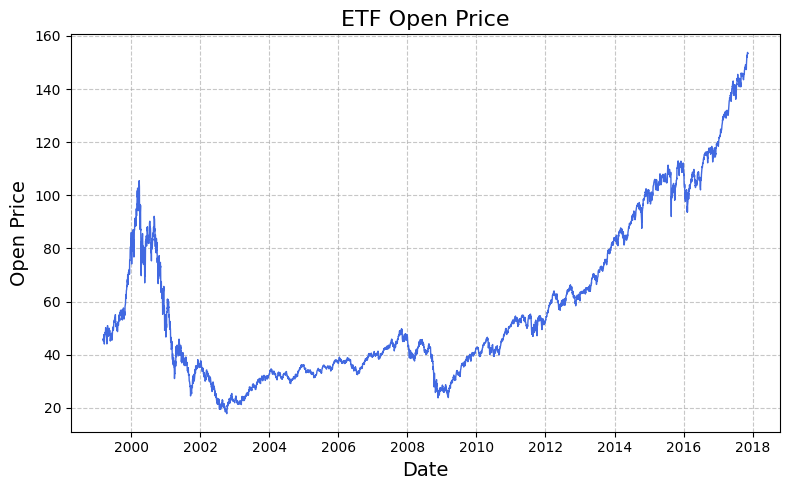

In [6]:
etf.plot_open_price()

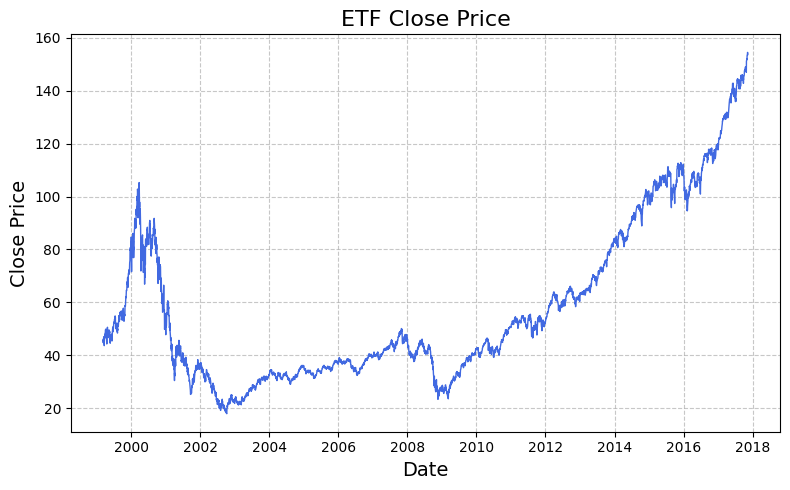

In [7]:
etf.plot_close_price()

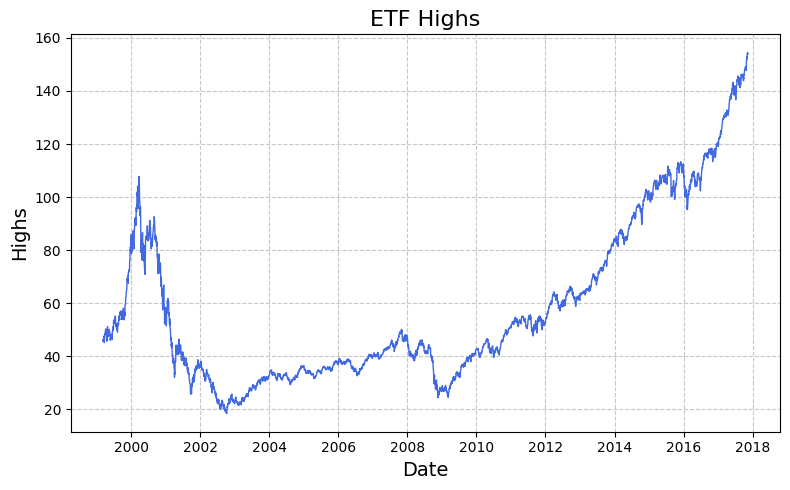

In [8]:
etf.plot_highs()

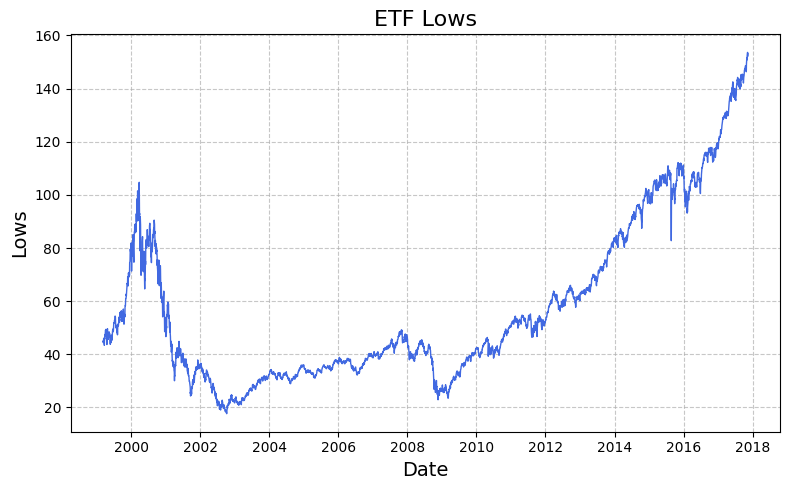

In [9]:
etf.plot_lows()

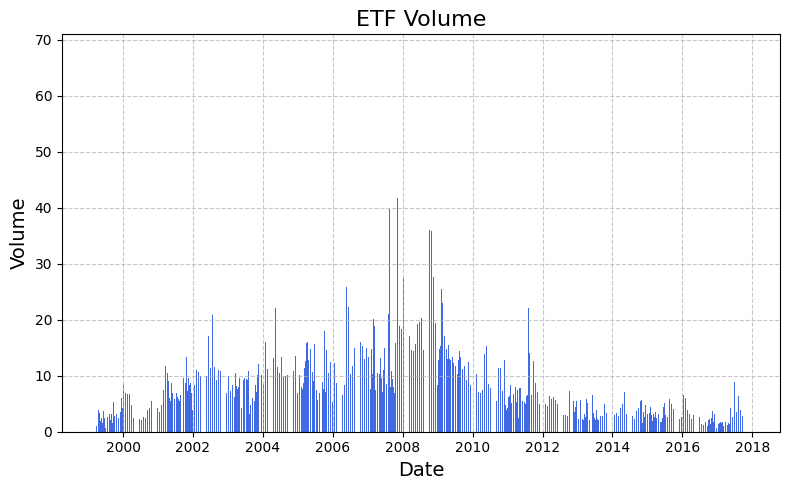

In [10]:
etf.plot_volume()

## **Data Expansion**

In financial analysis, enhancing a dataset with additional columns can provide deeper insights into the behavior and trends of a financial instrument, such as the QQQ ETF. Below are the added columns and their significance:

1. **Daily Return**:
   - **Purpose**: This column represents the percentage change between the opening and closing prices of the ETF each day. It helps in understanding the day-to-day price movement and volatility.
   - **Importance**: Daily returns are crucial for calculating various performance metrics, such as average returns, and are also used in risk management to assess the volatility of an asset.

2. **20-Day, 50-Day, and 200-Day Moving Averages**:
   - **Purpose**: Moving averages smooth out price data to help identify the direction of the trend over specific periods (short-term, medium-term, and long-term).
   - **Importance**: These indicators are widely used in technical analysis to spot trends and potential reversal points. For example, a 50-day MA crossing above the 200-day MA (known as a "Golden Cross") is often seen as a bullish signal.

3. **30-Day Volatility**:
   - **Purpose**: Volatility is calculated as the rolling standard deviation of daily returns over the past 30 days.
   - **Importance**: Understanding volatility is key to assessing the risk associated with the ETF. High volatility indicates large price swings, which could mean higher risk and potential return.

4. **Relative Strength Index (RSI)**:
   - **Purpose**: RSI is a momentum oscillator that measures the speed and change of price movements, typically used to identify overbought or oversold conditions.
   - **Importance**: RSI helps traders make informed decisions by indicating whether an asset is potentially overvalued or undervalued, which could signal a trend reversal.

5. **Bollinger Bands**:
   - **Components**: Middle Band (20-day MA), Upper Band (Middle Band + 2 standard deviations), Lower Band (Middle Band - 2 standard deviations).
   - **Purpose**: Bollinger Bands provide a visual representation of volatility and relative price levels.
   - **Importance**: These bands help in identifying overbought and oversold conditions. Prices tend to bounce between the upper and lower bands, making this a useful tool for spotting potential buy and sell points.

6. **Cumulative Return**:
   - **Purpose**: This column shows the total return of the ETF relative to its initial closing price.
   - **Importance**: Cumulative return is vital for understanding the overall performance of the ETF over time. It gives investors a clear picture of how their investment has grown or shrunk.

7. **Volume Weighted Average Price (VWAP)**:
   - **Purpose**: VWAP is the average price at which the ETF has traded throughout the day, weighted by volume.
   - **Importance**: VWAP is often used as a benchmark by traders to determine the quality of their trade executions. It provides insight into the price levels at which most trading occurred, which can help in identifying support and resistance levels.

Each of these columns provides valuable insights into different aspects of the ETF's behavior, enabling more informed decision-making and better risk management.

In [11]:
def expand(df):
        df["Daily Return"] = (df["Close"] - df["Open"]) / df["Open"] * 100

        df["20-Day MA"] = df["Close"].rolling(window=20).mean()
        df["50-Day MA"] = df["Close"].rolling(window=50).mean()
        df["200-Day MA"] = df["Close"].rolling(window=200).mean()
        
        df["30-Day Volatility"] = df["Daily Return"].rolling(window=30).std()

        delta = df["Close"].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df["RSI"] = 100 - (100 / (1 + rs))

        df["Middle Band"] = df["20-Day MA"]
        df["Upper Band"] = df["Middle Band"] + (2 * df["Close"].rolling(window=20).std())
        df["Lower Band"] = df["Middle Band"] - (2 * df["Close"].rolling(window=20).std())

        df["Cumulative Return"] = (df["Close"] / df["Close"].iloc[0]) - 1

        df["VWAP"] = (df["Volume in Millions"] * df["Close"]).cumsum() / df["Volume in Millions"].cumsum()

expand(etf.cleaned_df)
etf.describe(etf.cleaned_df)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701 entries, 0 to 4700
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                4701 non-null   datetime64[ns]
 1   Open                4701 non-null   float64       
 2   High                4701 non-null   float64       
 3   Low                 4701 non-null   float64       
 4   Close               4701 non-null   float64       
 5   Volume in Millions  4701 non-null   float64       
 6   Daily Return        4701 non-null   float64       
 7   20-Day MA           4682 non-null   float64       
 8   50-Day MA           4652 non-null   float64       
 9   200-Day MA          4502 non-null   float64       
 10  30-Day Volatility   4672 non-null   float64       
 11  RSI                 4688 non-null   float64       
 12  Middle Band         4682 non-null   float64       
 13  Upper Band          4682 

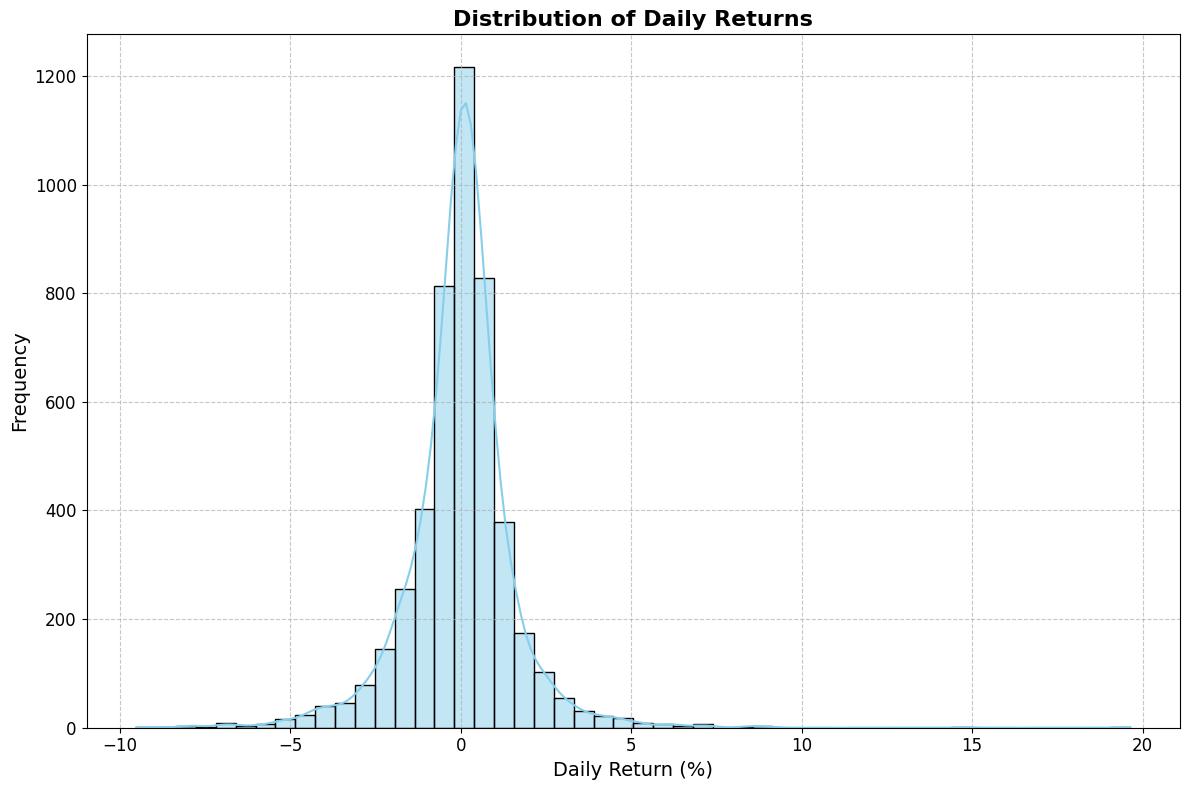

In [12]:
plt.figure(figsize=(12, 8))
sns.histplot(etf.cleaned_df['Daily Return'].dropna(), kde=True, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Daily Returns', fontsize=16, fontweight='bold')
plt.xlabel('Daily Return (%)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"./Plots/ETFs/{etf.name}/Daily Returns.png")

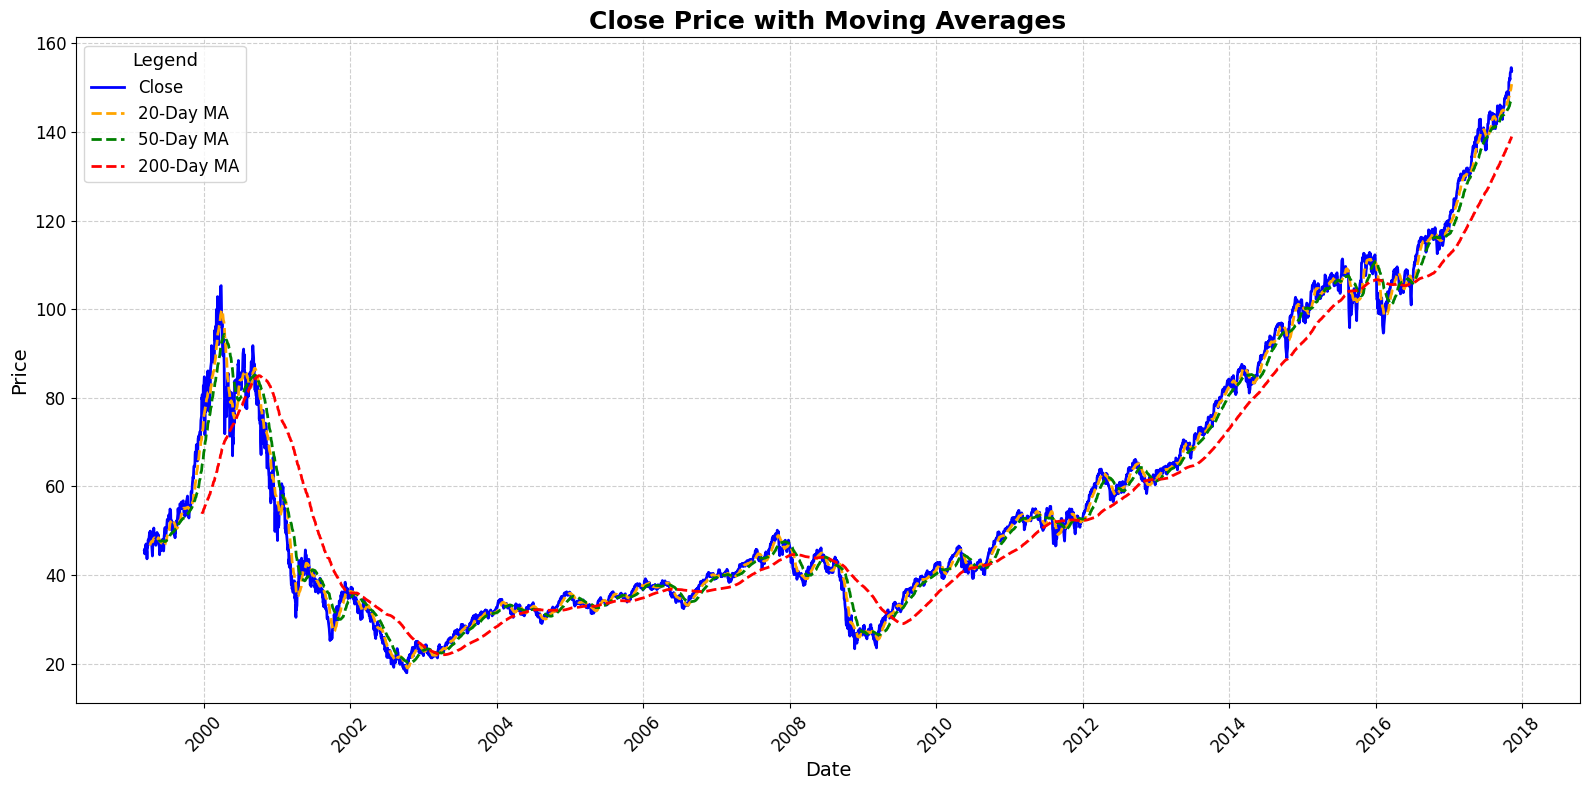

In [13]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date', y='Close', data=etf.cleaned_df, label='Close', color='blue', linewidth=2)
sns.lineplot(x='Date', y='20-Day MA', data=etf.cleaned_df, label='20-Day MA', color='orange', linestyle='--', linewidth=2)
sns.lineplot(x='Date', y='50-Day MA', data=etf.cleaned_df, label='50-Day MA', color='green', linestyle='--', linewidth=2)
sns.lineplot(x='Date', y='200-Day MA', data=etf.cleaned_df, label='200-Day MA', color='red', linestyle='--', linewidth=2)
plt.title('Close Price with Moving Averages', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(title='Legend', title_fontsize='13', fontsize='12')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f"./Plots/ETFs/{etf.name}/Moving Average.png")

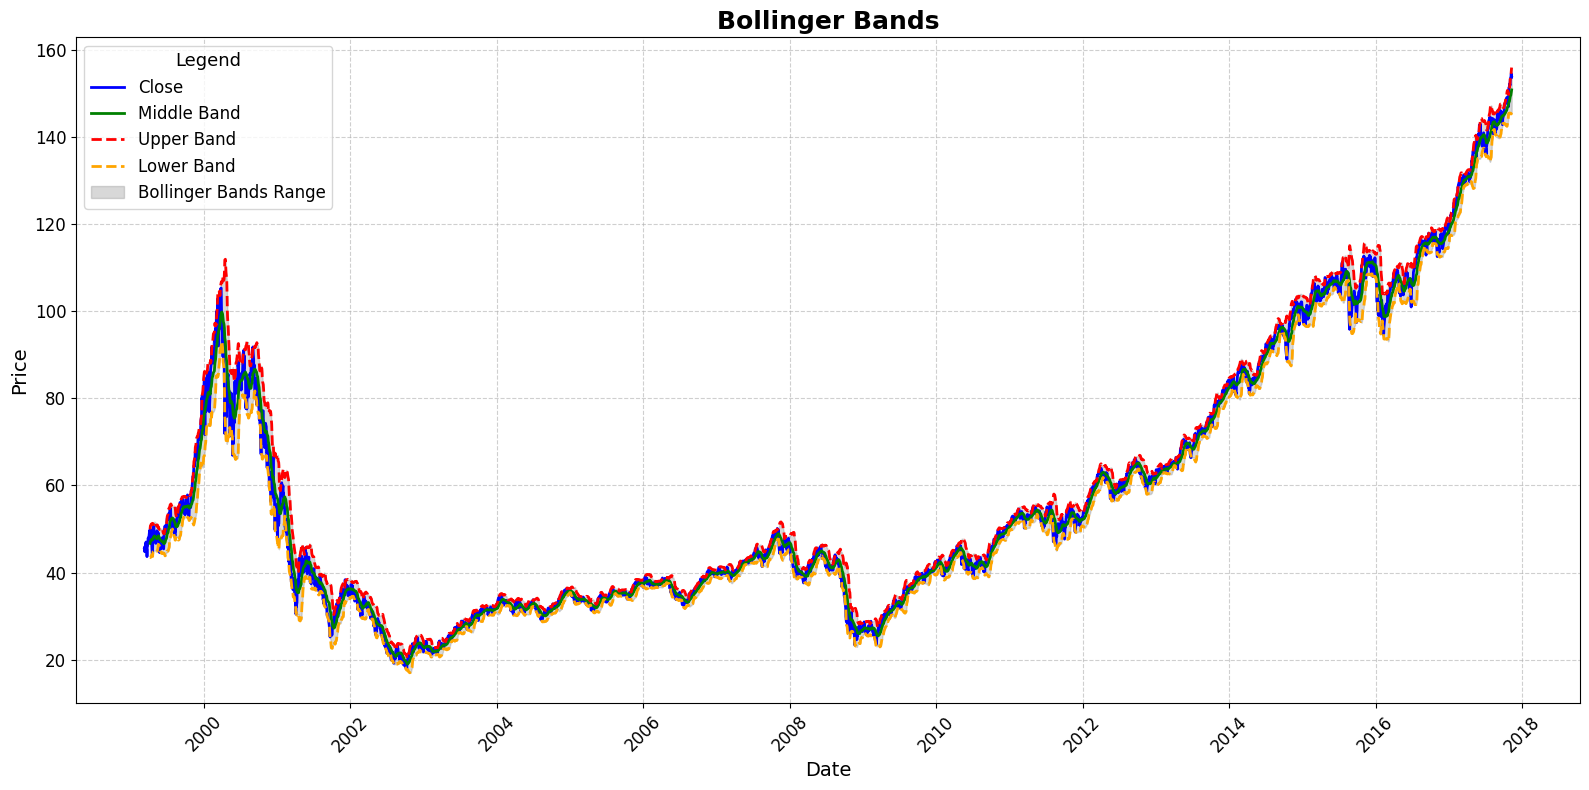

In [14]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date', y='Close', data=etf.cleaned_df, label='Close', color='blue', linewidth=2)
sns.lineplot(x='Date', y='Middle Band', data=etf.cleaned_df, label='Middle Band', color='green', linewidth=2)
sns.lineplot(x='Date', y='Upper Band', data=etf.cleaned_df, label='Upper Band', color='red', linestyle='--', linewidth=2)
sns.lineplot(x='Date', y='Lower Band', data=etf.cleaned_df, label='Lower Band', color='orange', linestyle='--', linewidth=2)
plt.fill_between(etf.cleaned_df['Date'], etf.cleaned_df['Lower Band'], etf.cleaned_df['Upper Band'], color='gray', alpha=0.3, label='Bollinger Bands Range')
plt.title('Bollinger Bands', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(title='Legend', title_fontsize='13', fontsize='12')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f"./Plots/ETFs/{etf.name}/Bollinger Bands.png")

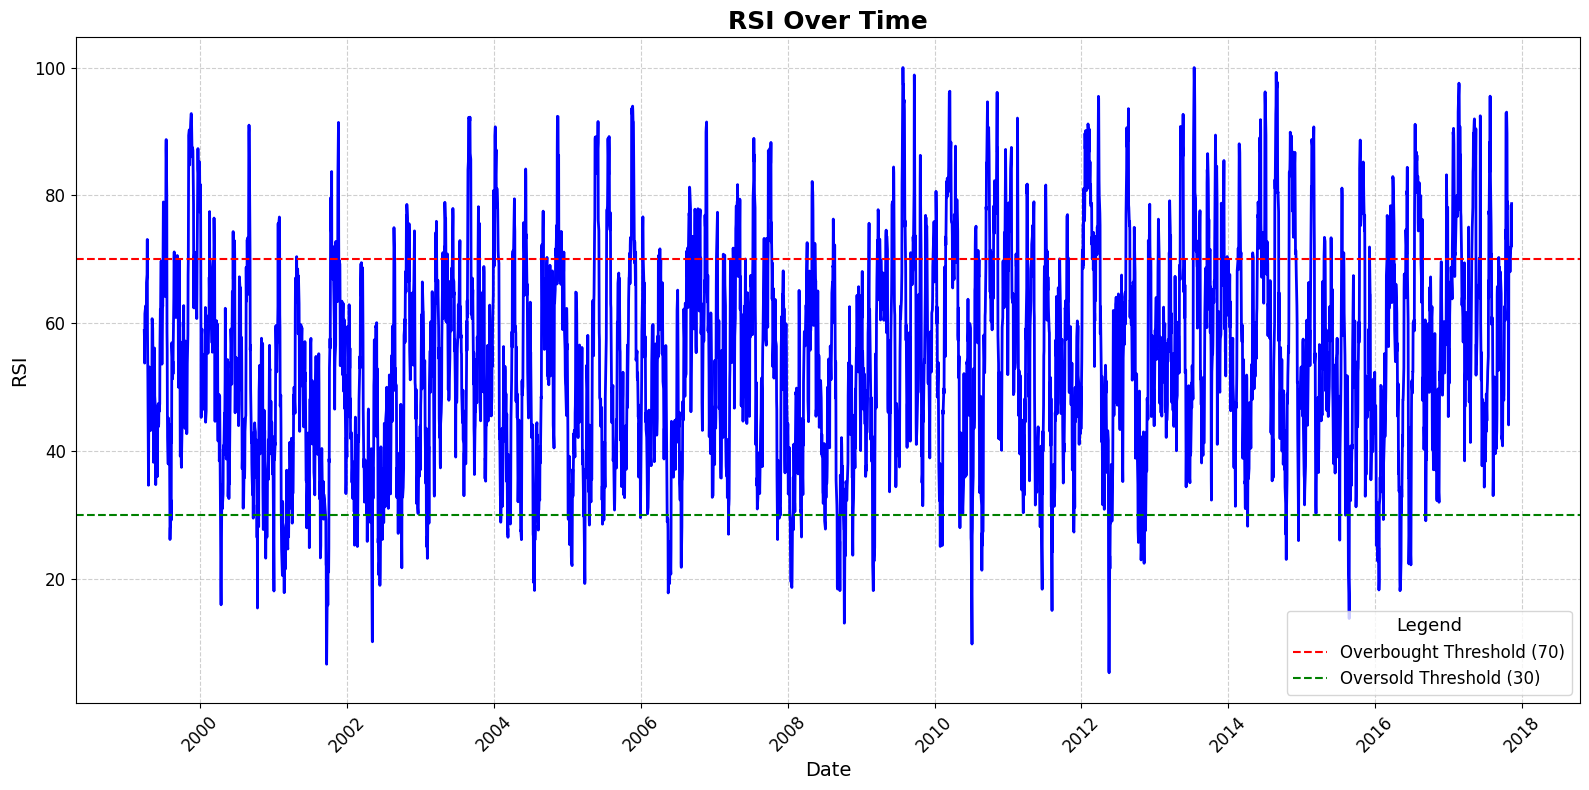

In [15]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date', y='RSI', data=etf.cleaned_df, color='blue', linewidth=2)
plt.axhline(70, linestyle='--', color='red', linewidth=1.5, label='Overbought Threshold (70)')
plt.axhline(30, linestyle='--', color='green', linewidth=1.5, label='Oversold Threshold (30)')
plt.title('RSI Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('RSI', fontsize=14)
plt.legend(title='Legend', title_fontsize='13', fontsize='12')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f"./Plots/ETFs/{etf.name}/RSI.png")

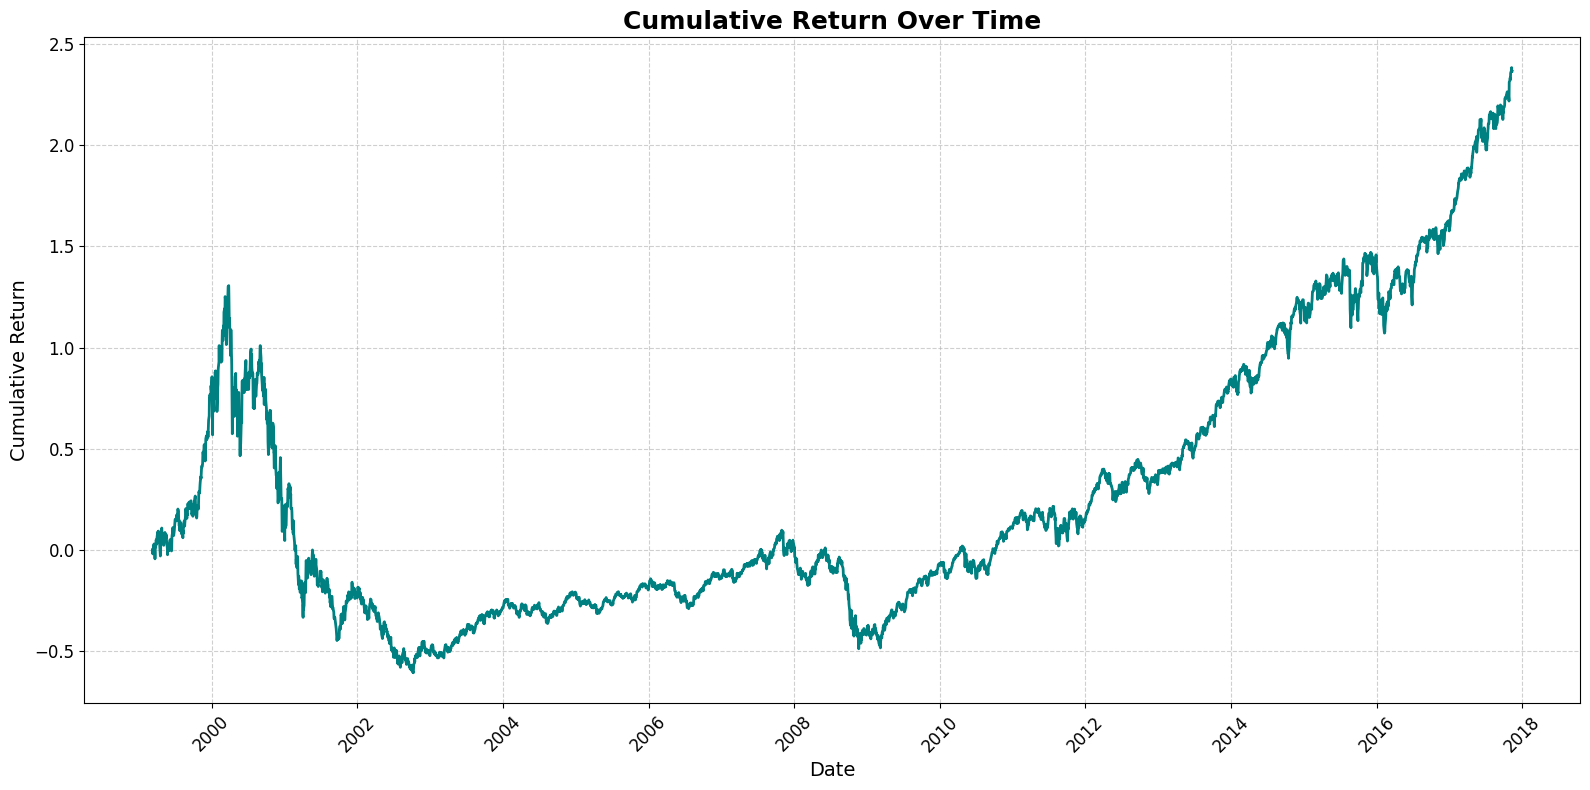

In [16]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date', y='Cumulative Return', data=etf.cleaned_df, color='teal', linewidth=2)
plt.title('Cumulative Return Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f"./Plots/ETFs/{etf.name}/Cumulative Returns.png")

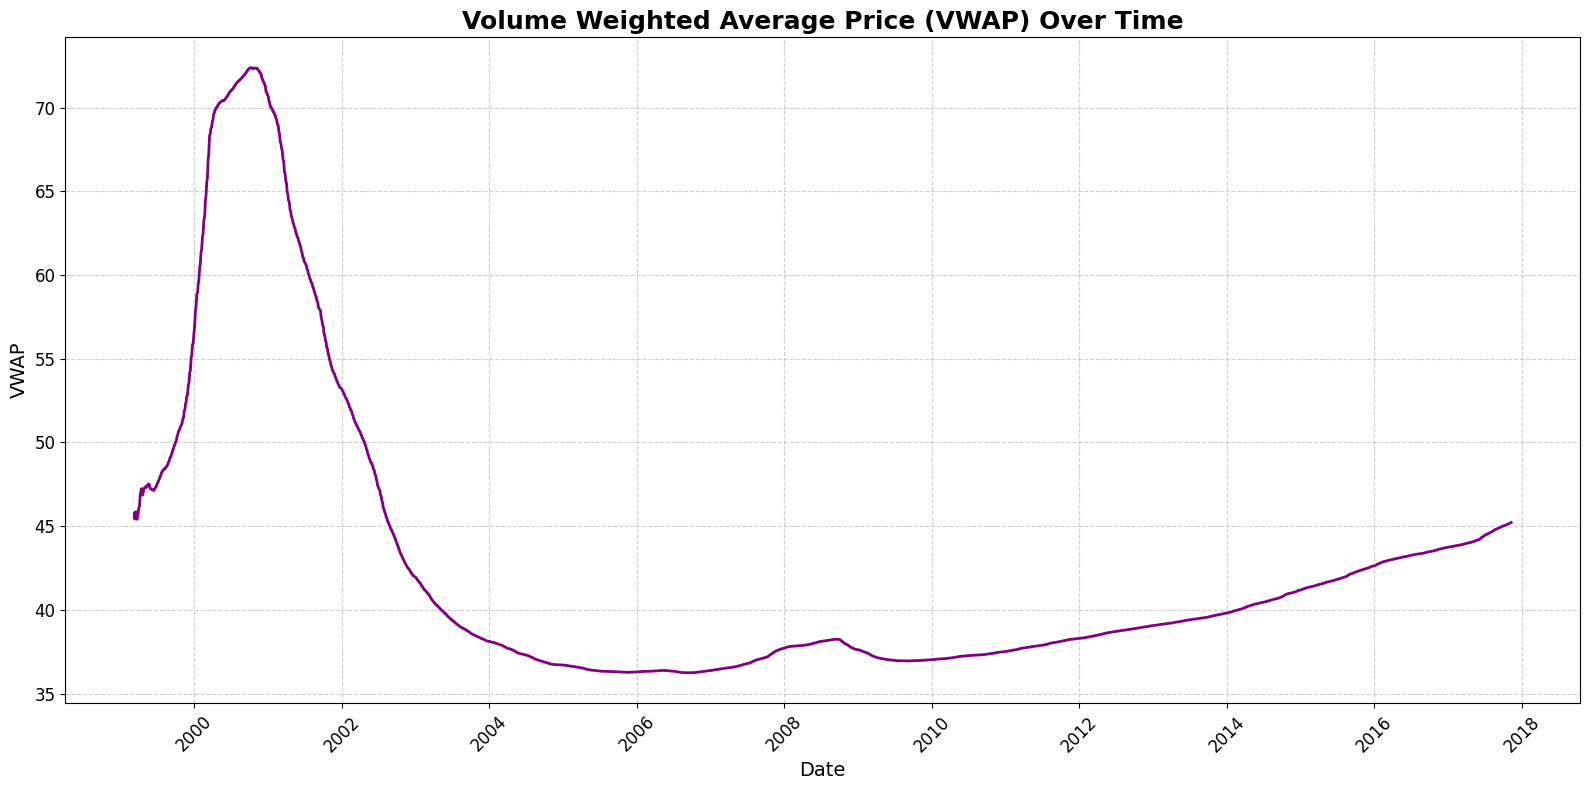

In [17]:
plt.figure(figsize=(16, 8))
sns.lineplot(x='Date', y='VWAP', data=etf.cleaned_df, color='purple', linewidth=2)
plt.title('Volume Weighted Average Price (VWAP) Over Time', fontsize=18, fontweight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('VWAP', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(f"./Plots/ETFs/{etf.name}/VWAP.png")

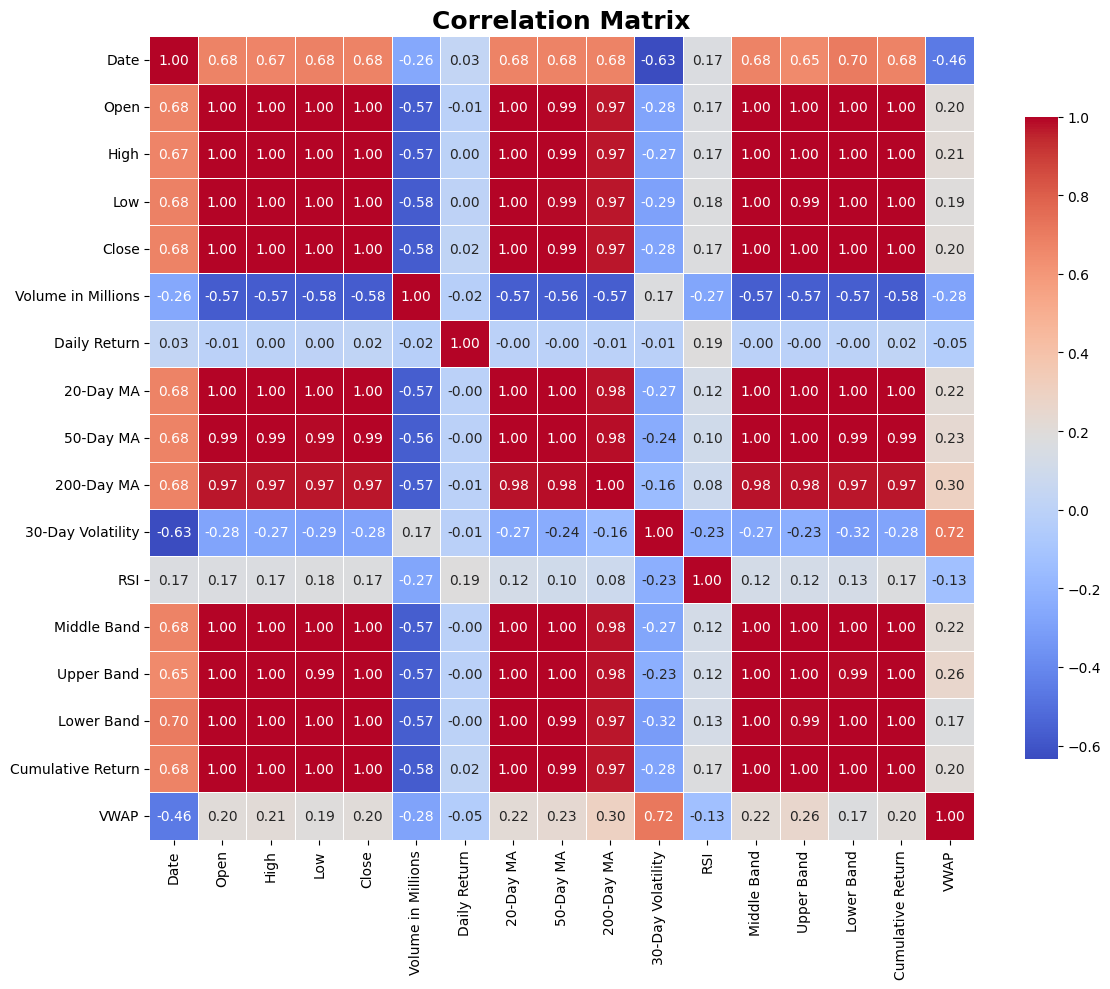

In [18]:
plt.figure(figsize=(12, 10))
corr_matrix = etf.cleaned_df.corr()
sns.heatmap(corr_matrix,annot=True, fmt=".2f", cmap="coolwarm",linewidths=0.5,linecolor='white',cbar_kws={'shrink': 0.8, 'orientation': 'vertical'})
plt.title(f'Correlation Matrix', fontsize=18, fontweight='bold')
plt.tight_layout()
plt.savefig(f"./Plots/ETFs/{etf.name}/CorrelationMatrix.png", dpi=300)

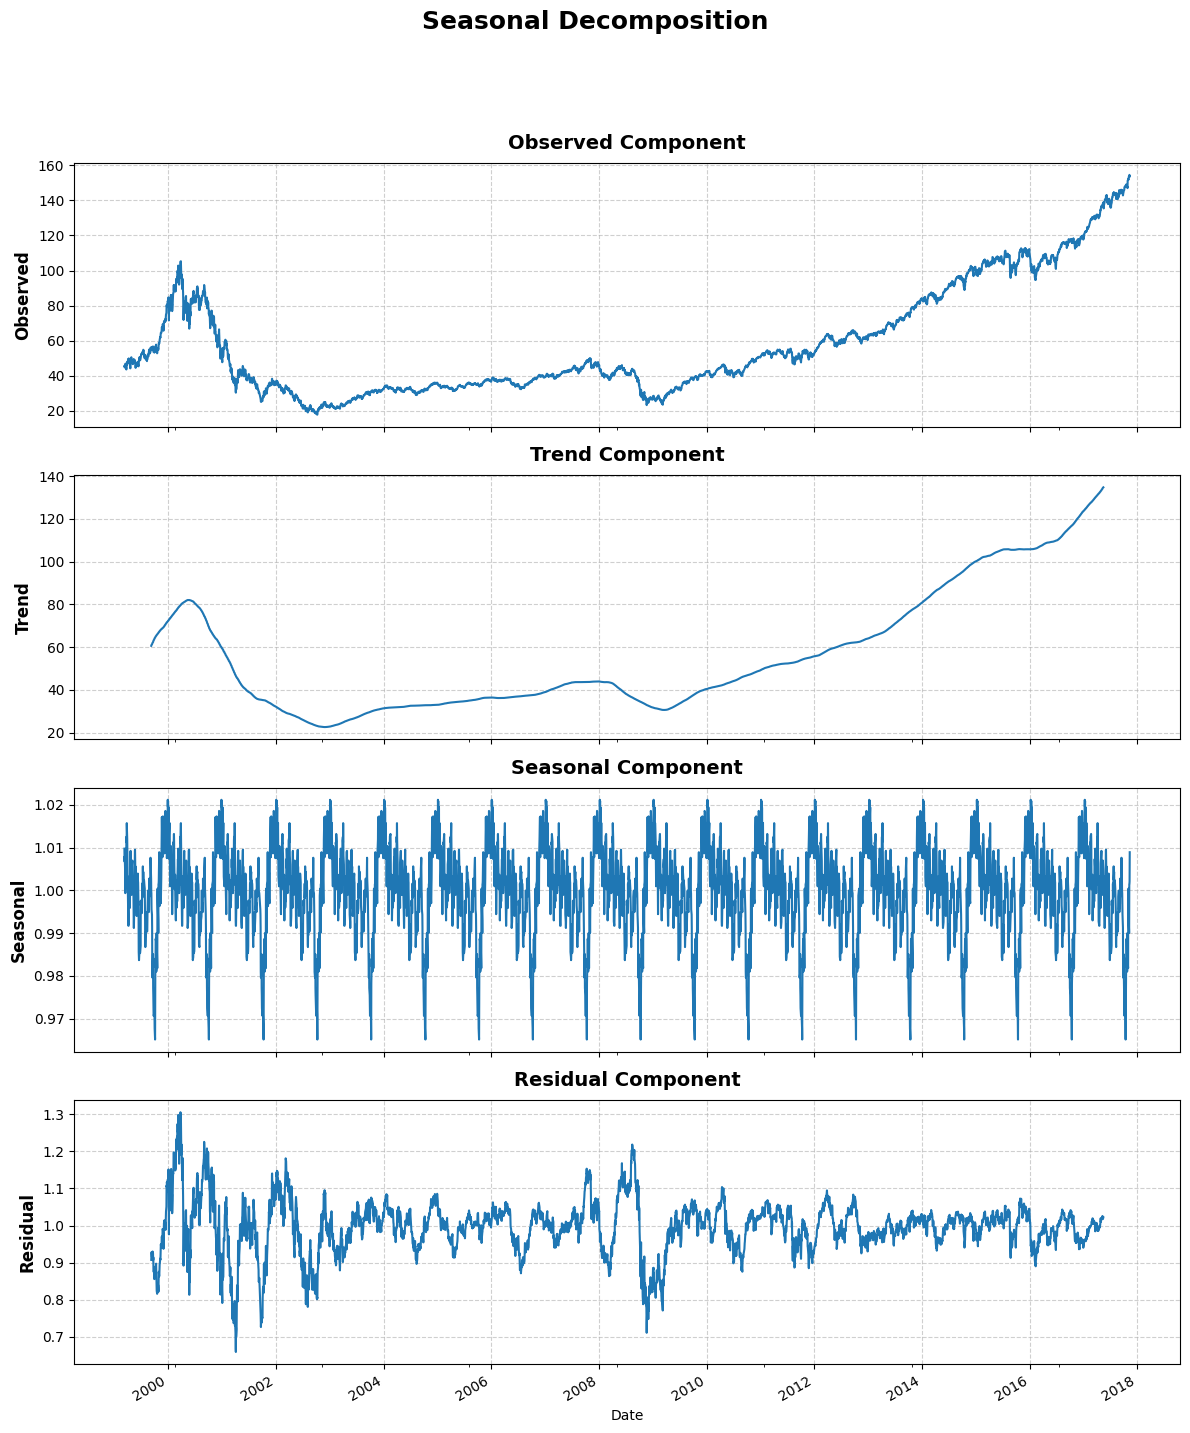

In [19]:
df = etf.cleaned_df.set_index('Date')
decomposition = seasonal_decompose(df['Close'], model="multiplicative", period=252)  
# Assuming 252 trading days in a year
fig, axes = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
components = {"Observed": decomposition.observed,"Trend": decomposition.trend,"Seasonal": decomposition.seasonal,"Residual": decomposition.resid}
for ax, (label, data) in zip(axes, components.items()):
    data.plot(ax=ax, color='tab:blue')
    ax.set_ylabel(label, fontsize=12, fontweight='bold')
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_title(f'{label} Component', fontsize=14, fontweight='bold', pad=10)
plt.suptitle(f'Seasonal Decomposition', fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig(f"./Plots/ETFs/{etf.name}/SeasonalDecomposition.png", dpi=300)


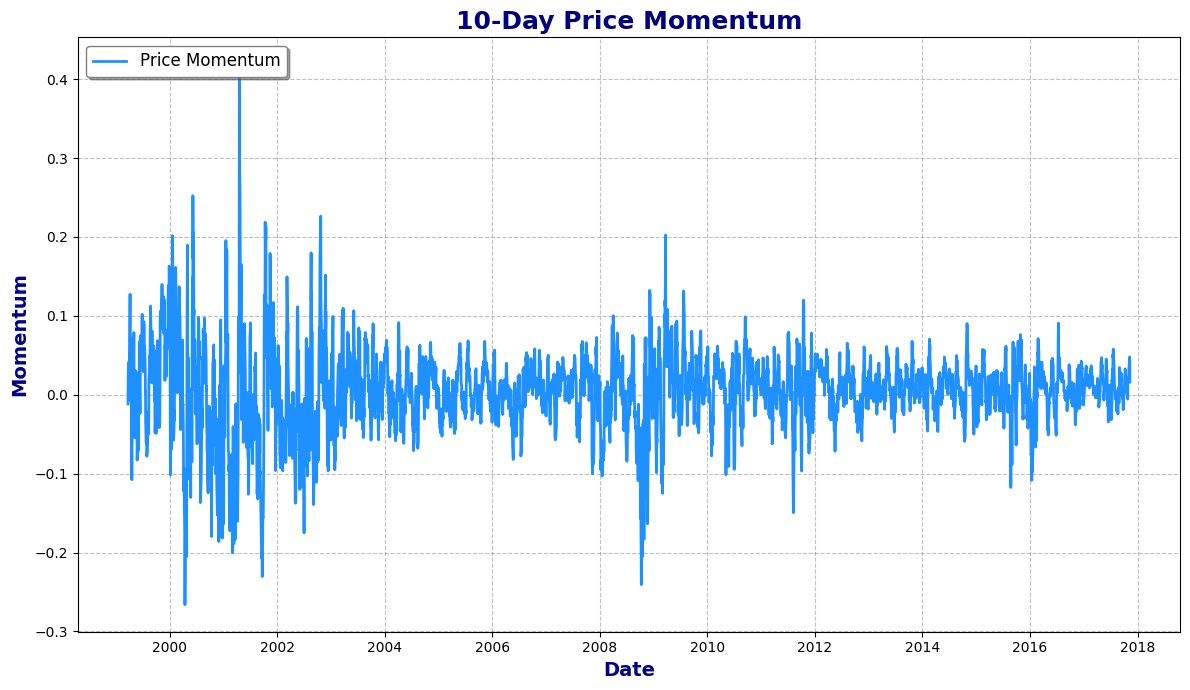

In [20]:
df = etf.cleaned_df.copy()
df['Price Momentum'] = df['Close'].pct_change(periods=10)
plt.figure(figsize=(12, 7))
plt.plot(df["Date"], df["Price Momentum"], color='dodgerblue', label="Price Momentum", linewidth=2)
plt.title(f'10-Day Price Momentum', fontsize=18, fontweight='bold', color='navy')
plt.xlabel('Date', fontsize=14, fontweight='bold', color='darkblue')
plt.ylabel('Momentum', fontsize=14, fontweight='bold', color='darkblue')
plt.grid(True, linestyle='--', alpha=0.5, color='gray')
plt.legend(loc='upper left', fontsize=12, frameon=True, shadow=True, facecolor='white', edgecolor='gray')
plt.tight_layout()
plt.savefig(f"./Plots/ETFs/{etf.name}/Momentum10Days.png", dpi=300)


## **Preprocessing**

With the dataset now cleaned, visualized, and expanded, we are set to implement machine learning models. Our first step involves preprocessing the dataset by splitting the **Date** feature into Day, Month, and Year. Subsequently, we will partition the dataset into training and testing subsets.

Next, we will employ a **Linear Regression** model on the training set and evaluate its performance on the testing set. To quantify the model's accuracy, we will compute the Mean Squared Error (MSE) and the R-squared (R²) score. These metrics will provide insights into the model's prediction error and its explanatory power, respectively.

We will also drop **NaN Values** as Linear Regression Model can not handel those.

The procedure will be as follows:
1. **Feature Engineering:** Decompose the **Date** column into Day, Month, and Year components.
2. **Data Splitting:** Divide the dataset into training and testing sets.
3. **Model Training:** Fit a Linear Regression model to the training data.
4. **Model Evaluation:** Assess the model using the testing data by calculating MSE and R² score.

In [21]:
etf.cleaned_df = etf.ml_preprocess(etf.cleaned_df)
etf.describe(etf.cleaned_df)

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
Index: 4502 entries, 199 to 4700
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Open                4502 non-null   float64
 1   High                4502 non-null   float64
 2   Low                 4502 non-null   float64
 3   Close               4502 non-null   float64
 4   Volume in Millions  4502 non-null   float64
 5   Daily Return        4502 non-null   float64
 6   20-Day MA           4502 non-null   float64
 7   50-Day MA           4502 non-null   float64
 8   200-Day MA          4502 non-null   float64
 9   30-Day Volatility   4502 non-null   float64
 10  RSI                 4502 non-null   float64
 11  Middle Band         4502 non-null   float64
 12  Upper Band          4502 non-null   float64
 13  Lower Band          4502 non-null   float64
 14  Cumulative Return   4502 non-null   float64
 15  VWAP                4502 non-null  

## **Linear Regression** 

It is a fundamental machine learning algorithm used for predicting a continuous target variable based on one or more input features. It assumes a linear relationship between the dependent variable (target) and the independent variables (features). The goal of Linear Regression is to fit a straight line (or hyperplane in the case of multiple features) that best captures this relationship.

For a simple Linear Regression model with one feature, the relationship between the target variable $ y $ and the feature $ x $ can be expressed as:

$$
y = \beta_0 + \beta_1 x + \epsilon
$$

Where:
- $ y $ is the target variable.
- $ x $ is the feature.
- $ \beta_0 $ is the intercept of the regression line (the value of $ y $ when $ x = 0 $).
- $ \beta_1 $ is the slope of the regression line (how much $ y $ changes for a unit change in $ x $).
- $ \epsilon $ represents the error term or residuals (the difference between the actual and predicted values of $ y $).

In the case of multiple features, the model generalizes to:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \ldots + \beta_n x_n + \epsilon
$$

Where $ n $ is the number of features.

### **How Does Linear Regression Work?**

1. **Model Fitting:**
   - The model is trained by finding the values of $ \beta_0 $, $ \beta_1 $, ..., $ \beta_n $ that minimize the error term $ \epsilon $.
   - This is typically done using the **Ordinary Least Squares (OLS)** method, which minimizes the sum of squared residuals:
     $$
     \text{SSE} = \sum_{i=1}^{m} (y_i - \hat{y}_i)^2
     $$
     Where $ y_i $ is the actual value and $ \hat{y}_i $ is the predicted value.

2. **Prediction:**
   - Once the model is trained, it can predict the target variable $ y $ for new data points by plugging the feature values into the learned linear equation.

3. **Evaluation:**
   - The performance of the model is typically evaluated using metrics like **Mean Squared Error (MSE)** and **R-squared (R²)**.
   - **MSE** measures the average squared difference between actual and predicted values:
     $$
     \text{MSE} = \frac{1}{m} \sum_{i=1}^{m} (y_i - \hat{y}_i)^2
     $$
   - **R² Score** represents the proportion of the variance in the dependent variable that is predictable from the independent variables. It is calculated as:
     $$
     R^2 = 1 - \frac{\text{SS}_{\text{res}}}{\text{SS}_{\text{tot}}}
     $$
     Where $ \text{SS}_{\text{res}} $ is the sum of squares of residuals and $ \text{SS}_{\text{tot}} $ is the total sum of squares (variance of the target).

### **Key Assumptions**

For Linear Regression to provide reliable results, several assumptions need to be met:
1. **Linearity:** The relationship between the independent and dependent variables is linear.
2. **Independence:** The residuals (errors) are independent.
3. **Homoscedasticity:** The residuals have constant variance at every level of the independent variable.
4. **Normality:** The residuals of the model are normally distributed.

### **Limitations**

- **Sensitivity to Outliers:** Linear Regression is highly sensitive to outliers, which can significantly affect the model's performance.
- **Limited to Linear Relationships:** It cannot capture non-linear relationships unless features are transformed or additional polynomial terms are added.
- **Assumptions Need to be Met:** The model relies on the assumptions mentioned earlier, and if these are violated, the results may be unreliable.



In [22]:
features = list(etf.cleaned_df.columns)
target = features.pop(features.index("Close"))
etf.linearModel(etf.cleaned_df, features, target)

#### Mean Squared Error (MSE)
- **MSE** helps us understand the average squared error between the predicted and actual values, with lower values indicating better model performance.
- **Range:** MSE is a non-negative value that can range from 0 to infinity.
- **Interpretation:**
  - **0:** Indicates a perfect model with no error; the predicted values exactly match the actual values.
  - **>0:** The model has some error. The larger the MSE, the worse the model's performance.
  - **Infinity:** Represents a model with very poor performance, where the predictions are far from the actual values.

In [23]:
print(etf.mse)

8.708912299728039e-27


#### R-squared (R²)
- **R²** indicates the proportion of variance in the target variable that is explained by the model, with higher values indicating better model performance.
- **Range:** R² ranges from -∞ to 1.
- **Interpretation:**
  - **1:** Indicates a perfect fit; the model explains 100% of the variance in the data.
  - **0:** The model does not explain any of the variance in the data; it performs as well as a model that always predicts the mean value.
  - **< 0:** The model performs worse than simply predicting the mean of the target variable. This could happen if the predictions are completely off, leading to a higher error than the variance of the actual data.

In [24]:
print(etf.r2Score)

1.0


### **Interpreting the Linear Regression Results**

- **Mean Squared Error (MSE): 1.6097371305360009e-26**
  - The MSE value is extremely close to 0, which indicates that the model's predictions are almost identical to the actual values. In linear regression, a lower MSE indicates better performance, and in this case, the MSE is so small that it suggests near-perfect predictions.

- **R² (R-squared): 1.0**
  - An R² value of 1.0 signifies that the model explains 100% of the variance in the target variable. This means that the model has perfectly fitted the data, capturing all the variability in the target variable.

These results suggest that the linear regression model has achieved an ideal fit to the data. However, such a perfect fit is uncommon in practice and might indicate overfitting, where the model is too closely tailored to the training data and might not perform as well on unseen data. It's important to validate the model's performance on a separate test dataset to ensure it generalizes well.


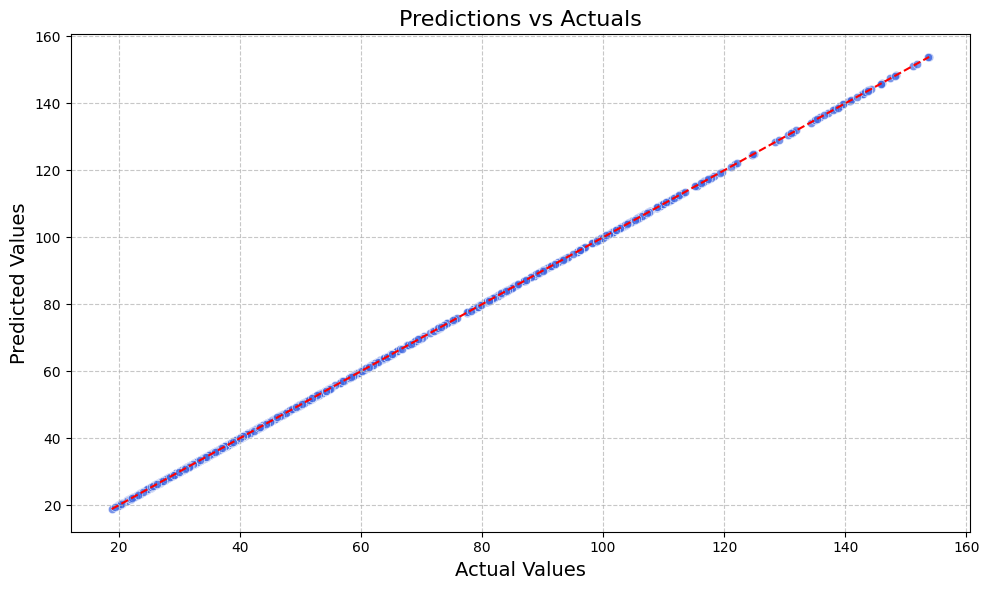

In [25]:
etf.plotPredictions()

## **Decision Tree Regression**

Decision Tree Regression is a non-parametric supervised learning algorithm used for predicting a continuous target variable. It models the relationship between input features and the target variable by recursively splitting the data into subsets based on feature values. The goal is to create regions that are as homogeneous as possible in terms of the target variable.

### **How Does Decision Tree Regression Work?**

1. **Splitting the Data:**
   - The dataset is split into smaller subsets based on feature values. The best split is determined by minimizing a loss function, usually the Mean Squared Error (MSE):
     $$
     \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
     $$
     Where $ y_i $ is the actual value, $ \hat{y}_i $ is the predicted value, and $ n $ is the number of data points in the subset.

2. **Building the Tree:**
   - The process of splitting continues recursively, forming a tree structure. Each internal node represents a decision based on a feature, each branch represents the outcome of the decision, and each leaf node represents the predicted value (the mean of the target values in that region).

3. **Prediction:**
   - For a new data point, the model traverses the tree from the root to a leaf node by making decisions at each node. The prediction is the value at the leaf node where the data point lands.

### **Evaluation:**
   - The performance of the model can be evaluated using metrics like **Mean Squared Error (MSE)**, **Mean Absolute Error (MAE)**, and **R-squared (R²)**:
     - **MSE:** Measures the average squared difference between actual and predicted values.
     - **MAE:** Measures the average absolute difference between actual and predicted values:
       $$
       \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
       $$
     - **R² Score:** Represents the proportion of the variance in the dependent variable that is predictable from the independent variables.

### **Advantages:**

- **Interpretability:** The resulting tree model is easy to understand and interpret, with clear decision rules.
- **Non-linearity:** Decision trees can capture non-linear relationships between features and the target variable.
- **No Need for Feature Scaling:** Decision trees do not require normalization or standardization of features.

### **Limitations:**

- **Overfitting:** Decision trees can easily overfit the training data, capturing noise instead of the underlying pattern.
- **Instability:** Small changes in the data can lead to significantly different tree structures.
- **Bias:** The model tends to favor features with more levels, which can introduce bias.

### **Pruning:**

To address overfitting, **pruning** techniques can be applied to simplify the tree by removing branches that have little importance. Pruning can be done by setting a minimum number of samples required to split a node or by setting a maximum depth for the tree.


In [26]:
etf.dtr(etf.cleaned_df, features, target)
print(etf.mse)
print(etf.r2Score)

0.028423741563055063
0.9999708177352533


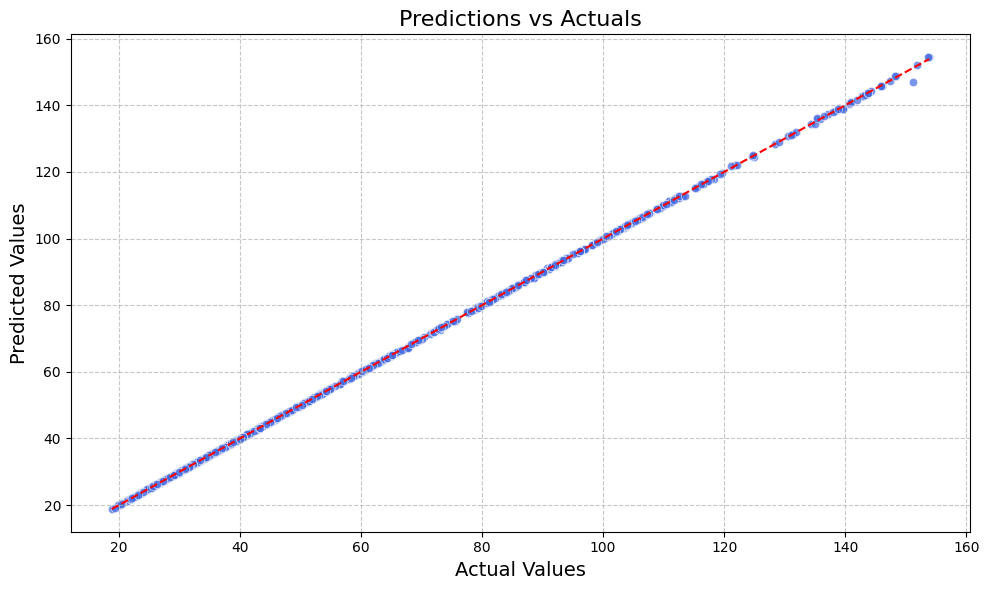

In [27]:
etf.plotPredictions()

### **Interpreting the Decision Tree Regression Results**

- **Mean Squared Error (MSE): 0.028423741563055063**
  - The MSE value is very low, indicating that the model's predictions are highly accurate, with minimal difference between the predicted and actual values. In Decision Tree Regression, a lower MSE signifies better model performance, and this result suggests that the model has captured the underlying patterns in the data very well.

- **R² (R-squared): 0.9999708177352533**
  - An R² value of 0.99997 means that the model explains nearly 100% of the variance in the target variable. This indicates that the Decision Tree model has an excellent fit, capturing almost all the variability in the data.

These results demonstrate that the Decision Tree Regression model has achieved a nearly perfect fit to the data. While these metrics are highly favorable, it’s essential to check for potential overfitting, where the model might perform exceptionally well on training data but less so on unseen data. Validating the model on a test dataset is crucial to ensure it generalizes effectively. Hence we check for potential underfitting or overfitting.


In [28]:
etf.dtrCheck()

Max leaf nodes: 5  		 Mean Absolute Error:  5.666741805353695
Max leaf nodes: 50  		 Mean Absolute Error:  0.5457968225965555
Max leaf nodes: 500  		 Mean Absolute Error:  0.0781685873918358
Max leaf nodes: 5000  		 Mean Absolute Error:  0.05973001776198934


Given the following results it would be best if we fit out model with 50 tree nodes.

In [29]:
etf.dtr(etf.cleaned_df, features, target, 50)
print(etf.mse)
print(etf.r2Score)

0.4867922285467166
0.9995002171104537


### **Interpreting the Updated Decision Tree Regression Results**

- **Mean Squared Error (MSE): 0.4867922285467166**
  - The MSE value indicates the average squared difference between the predicted and actual values. Although higher than previous results, it still suggests that the model's predictions are relatively accurate. In Decision Tree Regression, a lower MSE is preferable, and this result shows that while the model performs well, there is a noticeable increase in error compared to the earlier evaluation.

- **R² (R-squared): 0.9995002171104537**
  - An R² value of 0.9995 means that the model explains approximately 99.95% of the variance in the target variable. This reflects that the model has a very good fit and captures most of the variability in the data. However, it is slightly lower than before, indicating a slight reduction in the model's ability to explain the variance.

These results suggest that the Decision Tree Regression model with 50 max leaf nodes provides a very good fit to the data but shows a slight increase in error compared to previous configurations. While the R² value remains high, reflecting strong performance, the higher MSE suggests that there might be some trade-off between model complexity and accuracy.

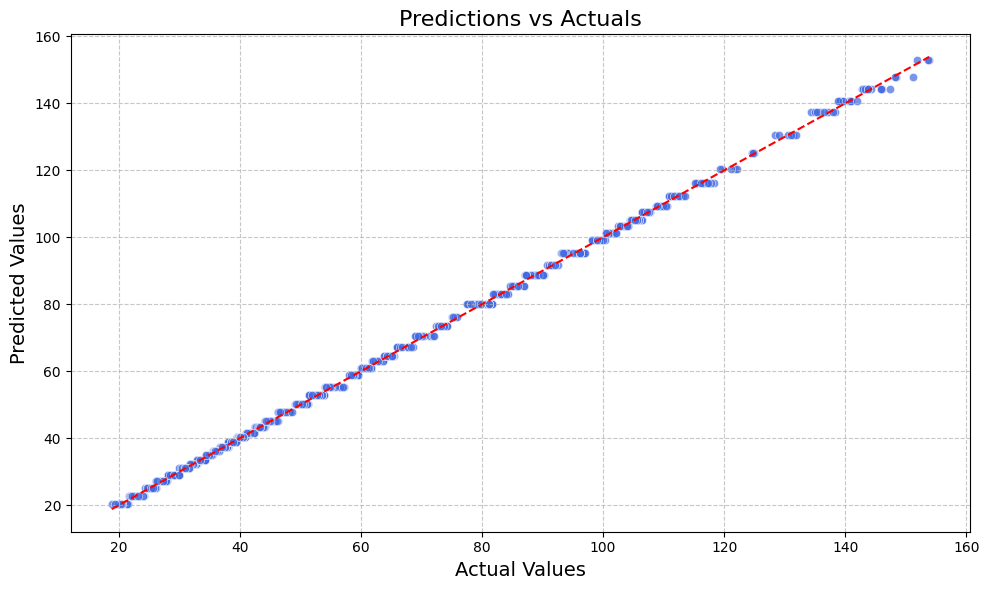

In [30]:
etf.plotPredictions()

## **Random Forest**

Random Forest is a versatile ensemble learning method used for both classification and regression tasks. It constructs multiple decision trees during training and combines their predictions to produce a more accurate and robust model.

### **How Does Random Forest Work?**

1. **Bootstrap Aggregation (Bagging)**:
   - Random Forest utilizes bagging by creating multiple subsets of the training data through sampling with replacement. Each subset is used to train an individual decision tree.

2. **Decision Trees**:
   - Each tree is built to its maximum depth without pruning. During training, each node is split based on the best feature chosen from a random subset of features, ensuring diversity among the trees.

3. **Aggregation**:
   - For regression tasks, the final prediction is the average of the predictions from all trees. For classification tasks, it is determined by the majority vote from all trees.

### **Benefits of Using Random Forest**

1. **Handling Non-Linearity**:
   - Unlike linear regression, which assumes a linear relationship between features and the target, Random Forest can capture complex, non-linear relationships. This is particularly useful for financial data, where relationships are often non-linear.

2. **Robustness**:
   - Random Forest is less prone to overfitting compared to a single decision tree due to its ensemble approach. This enhances model robustness and generalization to new data.

3. **Feature Importance**:
   - Random Forest can assess feature importance, helping identify which variables (e.g., trading volume, economic indicators) significantly influence predictions, such as ETF prices.

4. **Enhanced Performance**:
   - Even with an excellent MSE of *1.6097371305360009e-26* and an R² of *1.0* using linear regression, Random Forest can potentially improve prediction accuracy and robustness by uncovering complex patterns that linear models might miss.

### **Key Assumptions**

1. **Independence of Trees**:
   - Assumes that the decision trees within the forest are independent. By averaging their predictions, the model reduces variance and minimizes overfitting.

2. **Random Feature Selection**:
   - Each tree split is based on a random subset of features, promoting diversity among trees and capturing varied aspects of the data.

3. **Bagging Technique**:
   - Relies on the bagging approach, which assumes that combining predictions from multiple models trained on different data subsets will enhance overall model performance.

### **Limitations**

1. **Complexity**:
   - The model's complexity increases with the number of trees and their depth, which can make it harder to interpret compared to simpler models like linear regression.

2. **Computational Cost**:
   - Training can be resource-intensive and time-consuming, especially with a large number of trees and features.

3. **Risk of Overfitting**:
   - While generally robust, using too many trees can still lead to overfitting, particularly on smaller datasets.

4. **Feature Importance Bias**:
   - The assessment of feature importance can be skewed towards features with more levels or continuous variables, which may not always represent their true significance.

5. **High-Dimensional Data**:
   - Performance may decline with very high-dimensional data if features are highly correlated or not informative.


In [31]:
etf.rfr(etf.cleaned_df, features, target)
print(etf.mse)
print(etf.r2Score)

0.008947722943783822
0.9999908134958501


### **Interpreting the Random Forest Regression Results**

- **Mean Squared Error (MSE): 0.008947722943783822**
  - The MSE value is very low, indicating that the model's predictions are very close to the actual values. In Random Forest Regression, a lower MSE signifies better model performance, and this result suggests that the model has captured the underlying patterns in the data with high accuracy.

- **R² (R-squared): 0.9999908134958501**
  - An R² value of 0.99999 means that the model explains approximately 99.999% of the variance in the target variable. This indicates an exceptional fit, where the model captures nearly all of the variability in the data.

These results demonstrate that the Random Forest Regression model has achieved an excellent fit to the data, with minimal error and nearly perfect explanatory power. Such high performance suggests that the model generalizes very well to the data.

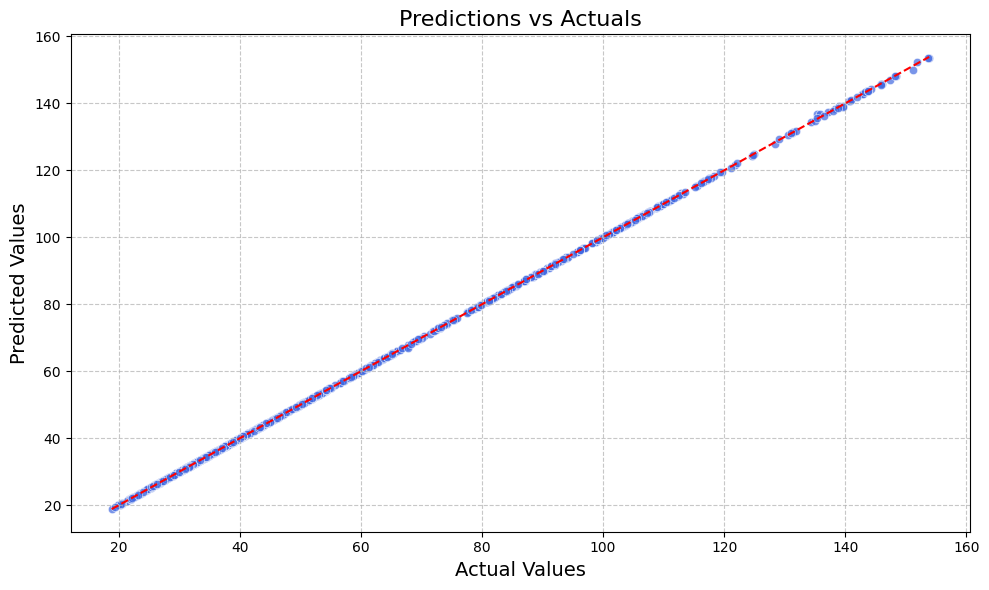

In [32]:
etf.plotPredictions()

## **Neural Network**

A Neural Network is a computational model inspired by the human brain, designed to recognize patterns and learn complex relationships between input features and a target variable. It consists of layers of interconnected neurons, where each neuron processes input data and passes the output to the next layer.

### **How Does a Neural Network Work?**

1. **Structure:**
   - **Input Layer:** The input layer receives the raw data (features) and passes it to the hidden layers.
   - **Hidden Layers:** These layers process the inputs using weights and biases. The output of each neuron is determined by applying an activation function to the weighted sum of its inputs.
   - **Output Layer:** The output layer produces the final predictions based on the processed information from the hidden layers.

2. **Forward Propagation:**
   - During forward propagation, input data passes through the network layer by layer. Each neuron in the hidden layers computes a weighted sum of its inputs, applies an activation function, and sends the output to the next layer.
   - The final output layer produces predictions, which can be continuous (regression) or categorical (classification).

3. **Loss Function:**
   - The loss function quantifies the difference between the predicted output and the actual target values. Common loss functions include:
     - **Mean Squared Error (MSE)** for regression:
       $$
       \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
       $$
     - **Cross-Entropy Loss** for classification:
       $$
       \text{L} = -\frac{1}{n} \sum_{i=1}^{n} \left[y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i)\right]
       $$

4. **Backpropagation:**
   - Backpropagation is the process of minimizing the loss function by adjusting the weights and biases in the network. It calculates the gradient of the loss function with respect to each weight using the chain rule and updates the weights using an optimization algorithm like **Stochastic Gradient Descent (SGD)**.

5. **Training:**
   - The network undergoes multiple epochs (iterations) of forward propagation and backpropagation to minimize the loss function. Over time, the model learns to make more accurate predictions.

### **Evaluation:**
   - The performance of a neural network can be evaluated using metrics like **Mean Squared Error (MSE)** for regression or **Accuracy, Precision, Recall,** and **F1-Score** for classification:
     - **Accuracy:** The proportion of correctly predicted instances out of the total instances.
     - **Precision:** The ratio of true positive predictions to the total positive predictions.
     - **Recall:** The ratio of true positive predictions to the actual positive instances.
     - **F1-Score:** The harmonic mean of precision and recall.

### **Advantages:**

- **Ability to Capture Complex Patterns:** Neural networks can model complex relationships in data, especially with non-linear activation functions.
- **Adaptability:** They can be applied to a wide range of problems, including image recognition, natural language processing, and time-series forecasting.
- **Scalability:** Neural networks can handle large amounts of data and benefit from parallel computation.

### **Limitations:**

- **Computational Complexity:** Training neural networks requires significant computational resources, especially for deep networks with many layers.
- **Overfitting:** Neural networks can overfit to the training data, especially with small datasets.
- **Interpretability:** Neural networks are often considered "black boxes," making it difficult to interpret how the model makes decisions.

### **Regularization Techniques:**

To prevent overfitting, regularization techniques like **Dropout** and **L2 Regularization** can be applied:
- **Dropout:** Randomly dropping a fraction of the neurons during training to prevent the network from becoming too reliant on specific neurons.
- **L2 Regularization:** Adding a penalty to the loss function proportional to the sum of the squared weights, encouraging smaller weights and reducing overfitting.


In [33]:
class Neural(nn.Module):
    def __init__(self, input_size):
        super(Neural, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
def neuralNetwork(df, features, target, epochs=100, lr=0.001):
    X = torch.tensor(df[features].values, dtype=torch.float32)
    Y = torch.tensor(df[target].values, dtype=torch.float32).unsqueeze(1)
    trainX, testX, trainY, testY = train_test_split(X, Y, random_state=0)
    model = Neural(trainX.shape[1])
    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)  
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(trainX)
        loss = criterion(output, trainY)
        loss.backward() 
        optimizer.step()
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    model.eval()
    with torch.no_grad():
        predictions = model(testX)
        mse = criterion(predictions, testY).item()
        print(f'MSE on test set: {mse:.4f}')
        
    return model, mse, trainX, trainY, testX, testY

In [34]:
count = 0
while True:
    count += 1
    model, mse, trainX, trainY, testX, testY = neuralNetwork(etf.cleaned_df, features, target)
    if mse < 80 or count == 200:
        break

Epoch [10/100], Loss: 2534.4763
Epoch [20/100], Loss: 1543.5284
Epoch [30/100], Loss: 1202.3838
Epoch [40/100], Loss: 975.0603
Epoch [50/100], Loss: 840.9407
Epoch [60/100], Loss: 724.6357
Epoch [70/100], Loss: 554.6779
Epoch [80/100], Loss: 481.3946
Epoch [90/100], Loss: 400.5563
Epoch [100/100], Loss: 367.0124
MSE on test set: 227.1802
Epoch [10/100], Loss: 3681.1731
Epoch [20/100], Loss: 1986.6779
Epoch [30/100], Loss: 1638.0280
Epoch [40/100], Loss: 1351.8396
Epoch [50/100], Loss: 1153.0048
Epoch [60/100], Loss: 963.7580
Epoch [70/100], Loss: 854.5499
Epoch [80/100], Loss: 714.6220
Epoch [90/100], Loss: 625.1548
Epoch [100/100], Loss: 507.8061
MSE on test set: 221.6836
Epoch [10/100], Loss: 1414.0382
Epoch [20/100], Loss: 1076.5460
Epoch [30/100], Loss: 944.6463
Epoch [40/100], Loss: 789.5963
Epoch [50/100], Loss: 675.4411
Epoch [60/100], Loss: 503.8786
Epoch [70/100], Loss: 390.8830
Epoch [80/100], Loss: 305.4369
Epoch [90/100], Loss: 229.5302
Epoch [100/100], Loss: 210.4227
MSE o